In [1]:
import os
from glob import glob
from pprint import pprint # pretty printing

# load the dreaded matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from scipy.io import wavfile # loading sound files
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets


# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Before we start, we need to make sure you have the right packages! run

`pip install matplotlib pandas numpy altair scipy ipywidgets vega_datasets notebook vega`


## 1. *Geddat that data*
we reduced our spiketime data into 'long' format data - where every row is an observation (in this case spikes) and every column a variable.

We also combined all cells into a single file with clean_out_dir.m. First lets find our file

In [35]:
# start with tuning curves
tc_dir = os.path.join(os.getcwd(),'data','sili_probes','TC')
# make a string with a wildcard to search for the file
tc_search = tc_dir + os.sep + "*combined*.csv"
tc_fns = glob(tc_search)

#what did we get?
print("""\nDirectory: {}
          \nSearch string: {}
          \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))



Directory: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC
          
Search string: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC/*combined*.csv
          
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC/out_combined_tones.csv']


Now load it!

In [36]:
if len(tc_fns) == 1:
    # make a pandas dataframe out of our .csv file
    df = pd.read_csv(tc_fns[0])
    
# print the first n rows (default 5, try giving another number as an argument)
#df.head()
df.head(10)

,amps,cell,dur,expt,freqs,rep,spikes
0,40,1,25,tuning_curve,1414.21,1,-15.800000
1,40,1,25,tuning_curve,1414.21,1,41.966667
2,40,1,25,tuning_curve,4000.00,1,-79.900000
3,40,1,25,tuning_curve,8000.00,1,9.700000
4,40,1,25,tuning_curve,11313.70,1,-80.300000
5,40,1,25,tuning_curve,22627.40,1,-8.900000
6,40,1,25,tuning_curve,22627.40,1,3.266667
7,40,1,25,tuning_curve,22627.40,1,25.333333
8,40,1,25,tuning_curve,22627.40,1,41.100000
9,40,1,25,tuning_curve,22627.40,1,79.166667


How many cells do we have?

In [37]:
# here we are using python string formatting, in general the format is
# add_string = "second sentence."
# "first sentence. {}".format(add_string) = "first sentence. second sentence."
# 

print("There are {} unique cells: {}".format(
        len(df['cell'].unique()), 
        df['cell'].unique()
    ))



There are 12 unique cells: [ 1 11 19 29 31 42 52 58 61 63 65 69]


The data is structured such that each row is a spike, and each column describes the spike.

Look at the rest of the column names - we have 

* **expt**: what type of experiment this data is from
* **freqs**: the frequency of the pure tone
* **amps**: the amplitude of the tone
* **rep**: the repetition of each amplitude/frequency combination
* **spikes**: the time of the spike (in ms from stimulus onset)

Lets check what `unique` frequencies and amplitudes we have

In [38]:
uq_freqs = df['freqs'].unique()
uq_amps  = df['amps'].unique()

print('Frequencies:\n')
pprint(uq_freqs)
print('\n\nAmplitudes:\n')
pprint(uq_amps)

Frequencies:

array([ 1.41421e+03,  4.00000e+03,  8.00000e+03,  1.13137e+04,
        2.26274e+04,  4.52548e+04,  6.40000e+04,  2.82843e+03,
        5.65685e+03,  1.60000e+04, -1.00000e+00,  2.00000e+03,
        3.20000e+04,  1.00000e+03])


Amplitudes:

array([40, 55, 70])


## 2. Spike Raster

We make a classic raster first.

I am trying out a new plotting library, [Altair](https://altair-viz.github.io), so refer to its documentation :)

In [39]:
def spike_raster(cell, data):
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
        
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # opaque
        color=alt.condition(      # and...
            # if the spike happened during the stimulus presentation
            (alt.datum.spikes >= 0) & (alt.datum.spikes<=alt.datum.dur), 
            alt.value('red'),     # colored red
            alt.value('black')    # otherwise black
        )
    ).properties(
        width = 200,
        height = 30,
    ).facet(
        row='freqs',  # split the plot into rows by frequency
        column='amps' # and columns by amplitude
    )
    
    return chart

To be able to plot separate rasters for each cell, we wrap the function that generates our plot in one, `interact`, that makes a selection box that regenerates the plot when the selection is changed

In [40]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDExLCAxOSwgMjksIDMxLCA0MiwgNTIsIDU4LCA2MSwgNjMsIDY1LCA2OSksIHbigKY=


## 3. Tuning Curves

What if we want to summarize? The receptive fields of auditory neurons are parameterized by the frequencies and amplitudes that drive spiking activity. We can map that by aggregating the spike trains across repetitions of the same sound.

Our summary will consist of...

1. Splitting our data into baseline spikes (before stimulus presentation) and spikes evoked by the stimulus
2. Counting the number of spikes that happen in each repetition of each stimulus
3. We want to measure the **change** in spiking activity due to the sound, so we subtract the baseline activity from the stimulus evoked activity
4. We then take the mean and standard deviation of baseline-subtracted spiking activity for each stimulus.
5. Plot it!

In [53]:
window = 75

# select just spikes within stim, aggregate
df_stim = df.loc[(df['spikes']>0) & (df['spikes']<window)]
# subset columns
df_stim = df_stim[['spikes','freqs','amps','cell','rep']]
# groupby cell, rep, and stim params, then count the number of spikes
df_stim = df_stim.groupby(['cell','freqs','amps','rep']).count()
# pandas is squirrelly, this just converts the data back into columns-only
df_stim = pd.DataFrame(df_stim.to_records())

# same for baseline
df_base = df.loc[(df['spikes']<0) & (df['spikes']>=window*-1.)]
df_base = df_base[['spikes','freqs','amps','cell','rep']]
df_base = df_base.groupby(['cell','freqs','amps','rep']).count()
df_base = pd.DataFrame(df_base.to_records())

## join
# join first to fill missing (0 spikes) values
# note that repetitions that have zero spikes at baseline or 
# during stim presentation will not be present in our summary,
# so sparsely firing cells will have spiking activity a bit high.
# that's fine for right now though...
df_tc = pd.merge(df_stim, df_base,
                 on=['cell','freqs', 'amps', 'rep'], how='outer')
# rename columns
df_tc.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'baseline'},
             inplace=True)

# fill nans
df_tc.fillna(0,inplace=True)

df_tc.head()




,cell,freqs,amps,rep,spikes,baseline
0,1,-1.0,40,14,1.0,0.0
1,1,-1.0,40,21,1.0,0.0
2,1,-1.0,55,5,1.0,0.0
3,1,-1.0,55,10,1.0,1.0
4,1,-1.0,55,11,2.0,0.0


In [54]:
# subtract
df_tc['spikes'] = df_tc['spikes']-df_tc['baseline']
# remove the other column
df_tc.drop('baseline', axis=1,inplace=True)

# divide by the duration to get mean spikes/s 
# (assuming durations uniform)
df_tc['spikes'] = df_tc['spikes']/(df['dur'][0]/1000.)

In [55]:
# aggregate over repetitions
df_tc_summary = df_tc.groupby(['cell','freqs','amps']).mean()
df_tc_std     = df_tc.groupby(['cell','freqs','amps']).std()

# the mean and std of the repetition number don't rly mean much here so we drop it
df_tc_summary.drop('rep',axis=1,inplace=True)
df_tc_std.drop('rep',axis=1,inplace=True)

df_tc_summary = pd.merge(df_tc_summary.reset_index(), df_tc_std.reset_index(),
                 on=['freqs', 'amps', 'cell'], how='outer')

# rename columns
df_tc_summary.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'std'},
             inplace=True)

df_tc_summary.head()




,cell,freqs,amps,spikes,std
0,1,-1.0,40,0.000000,46.188022
1,1,-1.0,55,20.000000,51.639778
2,1,-1.0,70,75.789474,39.765394
3,1,1000.0,40,5.714286,48.599432
4,1,1000.0,55,0.000000,56.568542


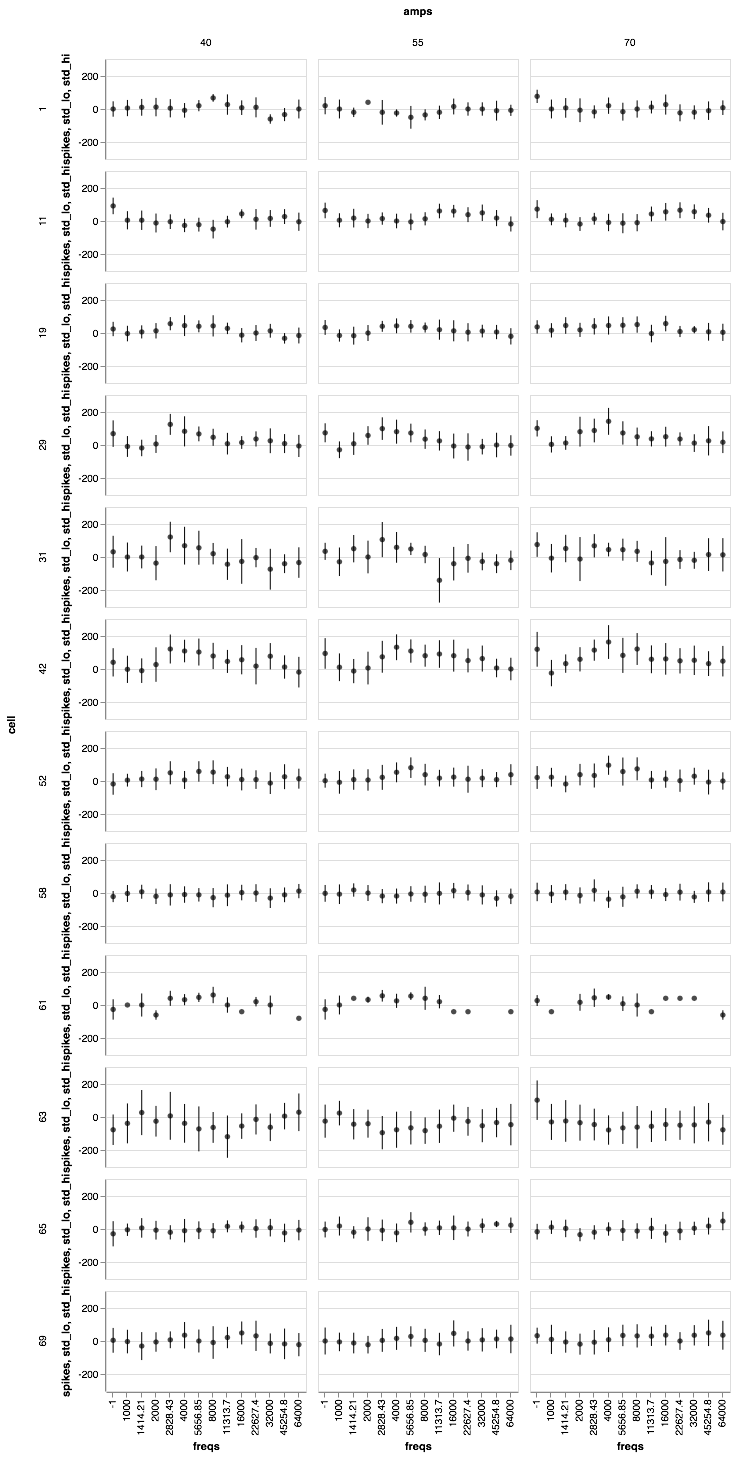

In [56]:
df_tc_summary['std_lo'] = df_tc_summary['spikes']-df_tc_summary['std']
df_tc_summary['std_hi'] = df_tc_summary['spikes']+df_tc_summary['std']

points = alt.Chart().mark_circle(
            ).encode(
                x=alt.X('freqs:O'),
                y=alt.Y('spikes:Q'),
                color=alt.value('black')
            ).properties(
                width = 200,
                height = 100
            )

bars = alt.Chart().mark_rule().encode(
y=alt.Y('std_lo:Q'),
y2=alt.Y('std_hi:Q'),
x=alt.X('freqs:O'))

chart = points+bars

chart.facet(row='cell:N',column='amps:O',data=df_tc_summary)


Or if we want to forget about uncertainty as a heatmap

In [57]:
def tc_heatmap(data, cell):
    points = alt.Chart(data[data['cell']==cell]).mark_rect(
                ).encode(
                    x=alt.X('freqs:O'),
                    y=alt.Y('amps:O'),
                    color='spikes:Q'
                ).properties(
                    width = 600,
                    height = 200
                )
    return points

In [58]:
interact(tc_heatmap,cell = sorted(df_tc_summary['cell'].unique()), data=fixed(df_tc_summary));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDExLCAxOSwgMjksIDMxLCA0MiwgNTIsIDU4LCA2MSwgNjMsIDY1LCA2OSksIHbigKY=


## 4. PINPed cells

Some cells in these animals have channelrhodopsin in them, and when exposed to blue light they spike. In order to see if we have those cells we measure the how reliably spikes are evoked by the light pulses

In [66]:
# find the file! this time let's wrap it in a function

def load_spikes(expt_type):

    # start with tuning curves
    tc_dir = os.path.join(os.getcwd(),'data','sili_probes',expt_type)
    # make a string with a wildcard to search for the file
    tc_search = tc_dir + os.sep + "*combined*.csv"
    tc_fns = glob(tc_search)

    #what did we get?
    print("""\nDirectory: {}
              \nSearch string: {}
              \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))
    
    if len(tc_fns) == 1:
        # make a pandas dataframe out of our .csv file
        df = pd.read_csv(tc_fns[0])
        return df
    else:
        print("Multiple or zero combined .csvs found, try again!")
        return None
    
pinp = load_spikes('PINP')
    
# print the first n rows (default 5, try giving another number as an argument)
pinp.head()


Directory: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP
              
Search string: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP/*combined*.csv
              
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP/out_combined_pinp.csv']


,cell,expt,isi,n_pulses,pulse_width,rep,spikes,type
0,1,pinp,NaN,NaN,20,1,-249.300000,pulse
1,1,pinp,NaN,NaN,20,1,-232.233333,pulse
2,1,pinp,NaN,NaN,20,1,-153.433333,pulse
3,1,pinp,NaN,NaN,20,2,157.300000,pulse
4,1,pinp,NaN,NaN,20,2,409.966667,pulse


Notice we have some NaNs right off the bat - notice our new column, 'type'

In [67]:
pinp['type'].unique()

array(['pulse', 'train'], dtype=object)

We have two types of stimuli, and the isi and n_pulses only apply to the 'train' type. Let's start with the single pulse though.

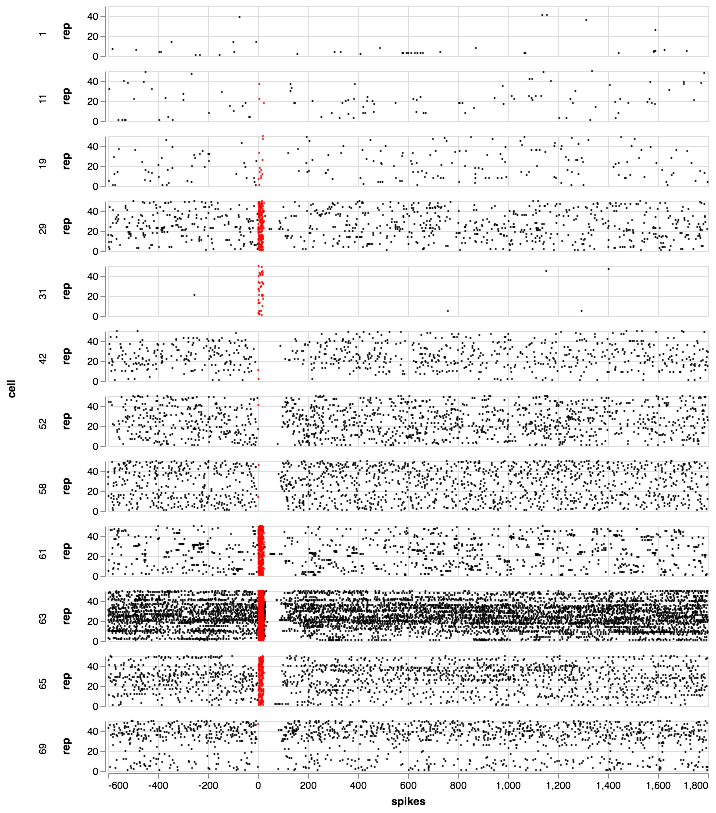

In [69]:
laser_slop = 5

chart = alt.Chart(pinp[pinp['type']=='pulse']).mark_circle().encode(
    x = alt.X('spikes'),      # X axis will be spike time
    y = alt.Y('rep' ),        # Y is the stimulus repetition
    size = alt.value(5),      # make the dots small
    opacity=alt.value(1.),    # opaque
    color=alt.condition(      # and...
        # if the spike happened during the stimulus presentation
        (alt.datum.spikes >= 0) & (alt.datum.spikes<=alt.datum.pulse_width+laser_slop), 
        alt.value('red'),     # colored red
        alt.value('black')    # otherwise black
    )
).properties(
    width = 600,
    height = 50,
).facet(
    row='cell',  # split the plot into rows by cell
)

chart

There should be some cells activated by the laser, some inhibited, and some unaffected. let's be a bit more quantitative.

In [70]:
# subset data
pinp_pulse = pinp[pinp['type']=='pulse']

# lets try it a slightly different way, with iteration
# first lets see what we're looking at
for i, group in pinp_pulse.groupby(['cell','rep']):
    print(i)
    print(group)

(1, 1)
   cell  expt  isi  n_pulses  pulse_width  rep      spikes   type
0     1  pinp  NaN       NaN           20    1 -249.300000  pulse
1     1  pinp  NaN       NaN           20    1 -232.233333  pulse
2     1  pinp  NaN       NaN           20    1 -153.433333  pulse
(1, 2)
   cell  expt  isi  n_pulses  pulse_width  rep      spikes   type
3     1  pinp  NaN       NaN           20    2  157.300000  pulse
4     1  pinp  NaN       NaN           20    2  409.966667  pulse
(1, 3)
    cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
5      1  pinp  NaN       NaN           20    3   577.433333  pulse
6      1  pinp  NaN       NaN           20    3   581.033333  pulse
7      1  pinp  NaN       NaN           20    3   594.733333  pulse
8      1  pinp  NaN       NaN           20    3   600.800000  pulse
9      1  pinp  NaN       NaN           20    3   613.000000  pulse
10     1  pinp  NaN       NaN           20    3   627.566667  pulse
11     1  pinp  NaN       NaN           2

176    11  pinp  NaN       NaN           20   21  1744.233333  pulse
(11, 22)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
177    11  pinp  NaN       NaN           20   22  -495.833333  pulse
178    11  pinp  NaN       NaN           20   22     5.366667  pulse
179    11  pinp  NaN       NaN           20   22   384.333333  pulse
180    11  pinp  NaN       NaN           20   22   621.166667  pulse
181    11  pinp  NaN       NaN           20   22  1024.733333  pulse
182    11  pinp  NaN       NaN           20   22  1249.566667  pulse
183    11  pinp  NaN       NaN           20   22  1448.766667  pulse
184    11  pinp  NaN       NaN           20   22  1566.300000  pulse
(11, 23)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
185    11  pinp  NaN       NaN           20   23  -369.700000  pulse
186    11  pinp  NaN       NaN           20   23   946.633333  pulse
187    11  pinp  NaN       NaN           20   23  1094.533333  pulse
(11, 24)
     ce

388    19  pinp  NaN       NaN           20   10  719.333333  pulse
(19, 11)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
389    19  pinp  NaN       NaN           20   11  1074.766667  pulse
390    19  pinp  NaN       NaN           20   11  1443.466667  pulse
391    19  pinp  NaN       NaN           20   11  1489.000000  pulse
392    19  pinp  NaN       NaN           20   11  1655.133333  pulse
(19, 12)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
393    19  pinp  NaN       NaN           20   12  -574.233333  pulse
394    19  pinp  NaN       NaN           20   12   -86.733333  pulse
395    19  pinp  NaN       NaN           20   12    17.566667  pulse
396    19  pinp  NaN       NaN           20   12   869.500000  pulse
397    19  pinp  NaN       NaN           20   12  1282.066667  pulse
(19, 13)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
398    19  pinp  NaN       NaN           20   13  -424.133333  pulse
399    1

     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
511    19  pinp  NaN       NaN           20   41  1055.966667  pulse
(19, 42)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
512    19  pinp  NaN       NaN           20   42  1282.066667  pulse
(19, 43)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
513    19  pinp  NaN       NaN           20   43   -65.100000  pulse
514    19  pinp  NaN       NaN           20   43  1187.933333  pulse
(19, 45)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
515    19  pinp  NaN       NaN           20   45   205.966667  pulse
516    19  pinp  NaN       NaN           20   45   754.600000  pulse
517    19  pinp  NaN       NaN           20   45  1049.700000  pulse
(19, 46)
     cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
518    19  pinp  NaN       NaN           20   46  -367.033333  pulse
519    19  pinp  NaN       NaN           20   46   449.866667  puls

972    29  pinp  NaN       NaN           20   13  1769.366667  pulse
(29, 14)
      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
973     29  pinp  NaN       NaN           20   14  -454.666667  pulse
974     29  pinp  NaN       NaN           20   14  -233.700000  pulse
975     29  pinp  NaN       NaN           20   14     6.233333  pulse
976     29  pinp  NaN       NaN           20   14     7.633333  pulse
977     29  pinp  NaN       NaN           20   14    10.933333  pulse
978     29  pinp  NaN       NaN           20   14    13.100000  pulse
979     29  pinp  NaN       NaN           20   14    15.133333  pulse
980     29  pinp  NaN       NaN           20   14    18.000000  pulse
981     29  pinp  NaN       NaN           20   14    20.733333  pulse
982     29  pinp  NaN       NaN           20   14   171.433333  pulse
983     29  pinp  NaN       NaN           20   14   355.733333  pulse
984     29  pinp  NaN       NaN           20   14   363.433333  pulse
985     29  

1337    29  pinp  NaN       NaN           20   29  1789.133333  pulse
(29, 30)
      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
1338    29  pinp  NaN       NaN           20   30  -561.500000  pulse
1339    29  pinp  NaN       NaN           20   30  -450.933333  pulse
1340    29  pinp  NaN       NaN           20   30  -416.166667  pulse
1341    29  pinp  NaN       NaN           20   30  -327.700000  pulse
1342    29  pinp  NaN       NaN           20   30   -38.600000  pulse
1343    29  pinp  NaN       NaN           20   30   -28.533333  pulse
1344    29  pinp  NaN       NaN           20   30   -19.966667  pulse
1345    29  pinp  NaN       NaN           20   30    10.333333  pulse
1346    29  pinp  NaN       NaN           20   30    17.566667  pulse
1347    29  pinp  NaN       NaN           20   30    23.900000  pulse
1348    29  pinp  NaN       NaN           20   30    85.966667  pulse
1349    29  pinp  NaN       NaN           20   30   355.966667  pulse
1350    29 

1671    29  pinp  NaN       NaN           20   48  1773.666667  pulse
(29, 49)
      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
1672    29  pinp  NaN       NaN           20   49  -460.800000  pulse
1673    29  pinp  NaN       NaN           20   49  -416.933333  pulse
1674    29  pinp  NaN       NaN           20   49  -348.633333  pulse
1675    29  pinp  NaN       NaN           20   49  -292.833333  pulse
1676    29  pinp  NaN       NaN           20   49  -275.766667  pulse
1677    29  pinp  NaN       NaN           20   49  -224.500000  pulse
1678    29  pinp  NaN       NaN           20   49  -187.166667  pulse
1679    29  pinp  NaN       NaN           20   49     1.966667  pulse
1680    29  pinp  NaN       NaN           20   49     4.266667  pulse
1681    29  pinp  NaN       NaN           20   49    13.600000  pulse
1682    29  pinp  NaN       NaN           20   49    14.733333  pulse
1683    29  pinp  NaN       NaN           20   49   147.600000  pulse
1684    29 

3246    42  pinp  NaN       NaN           20    3  1769.433333  pulse
(42, 4)
      cell  expt  isi  n_pulses  pulse_width  rep  spikes   type
3247    42  pinp  NaN       NaN           20    4  -433.2  pulse
(42, 5)
      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
3248    42  pinp  NaN       NaN           20    5  1292.666667  pulse
(42, 6)
      cell  expt  isi  n_pulses  pulse_width  rep      spikes   type
3249    42  pinp  NaN       NaN           20    6 -110.966667  pulse
3250    42  pinp  NaN       NaN           20    6  470.533333  pulse
(42, 7)
      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
3251    42  pinp  NaN       NaN           20    7  -295.633333  pulse
3252    42  pinp  NaN       NaN           20    7   367.266667  pulse
3253    42  pinp  NaN       NaN           20    7   512.700000  pulse
3254    42  pinp  NaN       NaN           20    7   578.866667  pulse
3255    42  pinp  NaN       NaN           20    7   586.033333  pulse
3

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
3492    42  pinp  NaN       NaN           20   21  -435.233333  pulse
3493    42  pinp  NaN       NaN           20   21  -324.800000  pulse
3494    42  pinp  NaN       NaN           20   21  -295.266667  pulse
3495    42  pinp  NaN       NaN           20   21  -279.466667  pulse
3496    42  pinp  NaN       NaN           20   21   123.466667  pulse
3497    42  pinp  NaN       NaN           20   21   127.133333  pulse
3498    42  pinp  NaN       NaN           20   21   182.966667  pulse
3499    42  pinp  NaN       NaN           20   21   323.400000  pulse
3500    42  pinp  NaN       NaN           20   21   373.366667  pulse
3501    42  pinp  NaN       NaN           20   21   695.766667  pulse
3502    42  pinp  NaN       NaN           20   21   720.633333  pulse
3503    42  pinp  NaN       NaN           20   21  1165.833333  pulse
3504    42  pinp  NaN       NaN           20   21  1279.066667  pulse
3505    42  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
3811    42  pinp  NaN       NaN           20   38  -258.633333  pulse
3812    42  pinp  NaN       NaN           20   38  -109.300000  pulse
3813    42  pinp  NaN       NaN           20   38   -93.500000  pulse
3814    42  pinp  NaN       NaN           20   38   238.500000  pulse
3815    42  pinp  NaN       NaN           20   38   269.700000  pulse
3816    42  pinp  NaN       NaN           20   38   360.900000  pulse
3817    42  pinp  NaN       NaN           20   38   369.000000  pulse
3818    42  pinp  NaN       NaN           20   38   470.666667  pulse
3819    42  pinp  NaN       NaN           20   38   479.866667  pulse
3820    42  pinp  NaN       NaN           20   38   495.400000  pulse
3821    42  pinp  NaN       NaN           20   38   518.300000  pulse
3822    42  pinp  NaN       NaN           20   38   569.600000  pulse
3823    42  pinp  NaN       NaN           20   38   622.500000  pulse
3824    42  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
4573    52  pinp  NaN       NaN           20    6  -459.700000  pulse
4574    52  pinp  NaN       NaN           20    6  -444.200000  pulse
4575    52  pinp  NaN       NaN           20    6  -439.833333  pulse
4576    52  pinp  NaN       NaN           20    6  -250.200000  pulse
4577    52  pinp  NaN       NaN           20    6  -236.133333  pulse
4578    52  pinp  NaN       NaN           20    6   -93.300000  pulse
4579    52  pinp  NaN       NaN           20    6   -69.833333  pulse
4580    52  pinp  NaN       NaN           20    6   249.500000  pulse
4581    52  pinp  NaN       NaN           20    6   308.066667  pulse
4582    52  pinp  NaN       NaN           20    6   328.933333  pulse
4583    52  pinp  NaN       NaN           20    6   342.200000  pulse
4584    52  pinp  NaN       NaN           20    6   345.833333  pulse
4585    52  pinp  NaN       NaN           20    6   521.633333  pulse
4586    52  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
4959    52  pinp  NaN       NaN           20   20  -454.633333  pulse
4960    52  pinp  NaN       NaN           20   20  -407.633333  pulse
4961    52  pinp  NaN       NaN           20   20  -268.233333  pulse
4962    52  pinp  NaN       NaN           20   20   -85.433333  pulse
4963    52  pinp  NaN       NaN           20   20   120.466667  pulse
4964    52  pinp  NaN       NaN           20   20   158.600000  pulse
4965    52  pinp  NaN       NaN           20   20   198.400000  pulse
4966    52  pinp  NaN       NaN           20   20   241.066667  pulse
4967    52  pinp  NaN       NaN           20   20   262.633333  pulse
4968    52  pinp  NaN       NaN           20   20   313.033333  pulse
4969    52  pinp  NaN       NaN           20   20   353.400000  pulse
4970    52  pinp  NaN       NaN           20   20   401.766667  pulse
4971    52  pinp  NaN       NaN           20   20   415.700000  pulse
4972    52  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
5383    52  pinp  NaN       NaN           20   35   117.566667  pulse
5384    52  pinp  NaN       NaN           20   35   127.733333  pulse
5385    52  pinp  NaN       NaN           20   35   131.800000  pulse
5386    52  pinp  NaN       NaN           20   35   218.166667  pulse
5387    52  pinp  NaN       NaN           20   35   226.966667  pulse
5388    52  pinp  NaN       NaN           20   35   317.600000  pulse
5389    52  pinp  NaN       NaN           20   35   330.000000  pulse
5390    52  pinp  NaN       NaN           20   35   338.300000  pulse
5391    52  pinp  NaN       NaN           20   35   568.566667  pulse
5392    52  pinp  NaN       NaN           20   35   580.733333  pulse
5393    52  pinp  NaN       NaN           20   35   681.066667  pulse
5394    52  pinp  NaN       NaN           20   35   718.166667  pulse
5395    52  pinp  NaN       NaN           20   35   756.066667  pulse
5396    52  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
6973    58  pinp  NaN       NaN           20    1  -579.866667  pulse
6974    58  pinp  NaN       NaN           20    1  -515.600000  pulse
6975    58  pinp  NaN       NaN           20    1  -376.800000  pulse
6976    58  pinp  NaN       NaN           20    1  -366.900000  pulse
6977    58  pinp  NaN       NaN           20    1  -215.300000  pulse
6978    58  pinp  NaN       NaN           20    1  -133.900000  pulse
6979    58  pinp  NaN       NaN           20    1  -124.766667  pulse
6980    58  pinp  NaN       NaN           20    1  -115.666667  pulse
6981    58  pinp  NaN       NaN           20    1   -48.400000  pulse
6982    58  pinp  NaN       NaN           20    1   142.233333  pulse
6983    58  pinp  NaN       NaN           20    1   182.433333  pulse
6984    58  pinp  NaN       NaN           20    1   280.533333  pulse
6985    58  pinp  NaN       NaN           20    1   336.333333  pulse
6986    58  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
7330    58  pinp  NaN       NaN           20   13  -587.333333  pulse
7331    58  pinp  NaN       NaN           20   13  -537.933333  pulse
7332    58  pinp  NaN       NaN           20   13  -470.533333  pulse
7333    58  pinp  NaN       NaN           20   13  -441.700000  pulse
7334    58  pinp  NaN       NaN           20   13  -411.833333  pulse
7335    58  pinp  NaN       NaN           20   13  -398.266667  pulse
7336    58  pinp  NaN       NaN           20   13  -359.466667  pulse
7337    58  pinp  NaN       NaN           20   13  -336.466667  pulse
7338    58  pinp  NaN       NaN           20   13  -324.133333  pulse
7339    58  pinp  NaN       NaN           20   13  -307.633333  pulse
7340    58  pinp  NaN       NaN           20   13  -286.800000  pulse
7341    58  pinp  NaN       NaN           20   13  -245.433333  pulse
7342    58  pinp  NaN       NaN           20   13  -198.900000  pulse
7343    58  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
7683    58  pinp  NaN       NaN           20   28  -576.733333  pulse
7684    58  pinp  NaN       NaN           20   28  -486.000000  pulse
7685    58  pinp  NaN       NaN           20   28  -441.300000  pulse
7686    58  pinp  NaN       NaN           20   28   -16.400000  pulse
7687    58  pinp  NaN       NaN           20   28   151.733333  pulse
7688    58  pinp  NaN       NaN           20   28   375.766667  pulse
7689    58  pinp  NaN       NaN           20   28   395.400000  pulse
7690    58  pinp  NaN       NaN           20   28   483.733333  pulse
7691    58  pinp  NaN       NaN           20   28   525.200000  pulse
7692    58  pinp  NaN       NaN           20   28   560.533333  pulse
7693    58  pinp  NaN       NaN           20   28   608.133333  pulse
7694    58  pinp  NaN       NaN           20   28   649.766667  pulse
7695    58  pinp  NaN       NaN           20   28   715.933333  pulse
7696    58  pinp  Na

      cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
8131    58  pinp  NaN       NaN           20   44  -463.400000  pulse
8132    58  pinp  NaN       NaN           20   44  -431.100000  pulse
8133    58  pinp  NaN       NaN           20   44  -412.966667  pulse
8134    58  pinp  NaN       NaN           20   44  -317.666667  pulse
8135    58  pinp  NaN       NaN           20   44  -198.733333  pulse
8136    58  pinp  NaN       NaN           20   44  -149.166667  pulse
8137    58  pinp  NaN       NaN           20   44   -91.266667  pulse
8138    58  pinp  NaN       NaN           20   44   -83.166667  pulse
8139    58  pinp  NaN       NaN           20   44    -9.733333  pulse
8140    58  pinp  NaN       NaN           20   44    -8.533333  pulse
8141    58  pinp  NaN       NaN           20   44   103.533333  pulse
8142    58  pinp  NaN       NaN           20   44   126.533333  pulse
8143    58  pinp  NaN       NaN           20   44   203.900000  pulse
8144    58  pinp  Na

10191    61  pinp  NaN       NaN           20    6  1648.533333  pulse
(61, 7)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
10192    61  pinp  NaN       NaN           20    7  -579.800000  pulse
10193    61  pinp  NaN       NaN           20    7  -559.433333  pulse
10194    61  pinp  NaN       NaN           20    7  -378.700000  pulse
10195    61  pinp  NaN       NaN           20    7  -363.766667  pulse
10196    61  pinp  NaN       NaN           20    7  -138.033333  pulse
10197    61  pinp  NaN       NaN           20    7  -116.866667  pulse
10198    61  pinp  NaN       NaN           20    7  -105.066667  pulse
10199    61  pinp  NaN       NaN           20    7   -86.433333  pulse
10200    61  pinp  NaN       NaN           20    7   -81.500000  pulse
10201    61  pinp  NaN       NaN           20    7   -79.000000  pulse
10202    61  pinp  NaN       NaN           20    7   -76.433333  pulse
10203    61  pinp  NaN       NaN           20    7   -74.166667  puls

10657    61  pinp  NaN       NaN           20   24  1338.633333  pulse
(61, 25)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
10658    61  pinp  NaN       NaN           20   25  -346.800000  pulse
10659    61  pinp  NaN       NaN           20   25  -276.866667  pulse
10660    61  pinp  NaN       NaN           20   25     4.133333  pulse
10661    61  pinp  NaN       NaN           20   25     8.766667  pulse
10662    61  pinp  NaN       NaN           20   25    10.900000  pulse
10663    61  pinp  NaN       NaN           20   25    12.000000  pulse
10664    61  pinp  NaN       NaN           20   25    14.800000  pulse
10665    61  pinp  NaN       NaN           20   25   246.766667  pulse
10666    61  pinp  NaN       NaN           20   25   304.666667  pulse
10667    61  pinp  NaN       NaN           20   25   311.133333  pulse
10668    61  pinp  NaN       NaN           20   25   313.066667  pulse
10669    61  pinp  NaN       NaN           20   25   636.066667  pul

11058    61  pinp  NaN       NaN           20   39  1762.166667  pulse
(61, 40)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
11059    61  pinp  NaN       NaN           20   40  -477.633333  pulse
11060    61  pinp  NaN       NaN           20   40     7.000000  pulse
11061    61  pinp  NaN       NaN           20   40     7.466667  pulse
11062    61  pinp  NaN       NaN           20   40    15.766667  pulse
11063    61  pinp  NaN       NaN           20   40   338.333333  pulse
11064    61  pinp  NaN       NaN           20   40   543.333333  pulse
11065    61  pinp  NaN       NaN           20   40   634.500000  pulse
11066    61  pinp  NaN       NaN           20   40   728.766667  pulse
11067    61  pinp  NaN       NaN           20   40   752.633333  pulse
11068    61  pinp  NaN       NaN           20   40   755.433333  pulse
11069    61  pinp  NaN       NaN           20   40   793.700000  pulse
11070    61  pinp  NaN       NaN           20   40   960.666667  pul

14287    63  pinp  NaN       NaN           20    3  1766.233333  pulse
(63, 4)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
14288    63  pinp  NaN       NaN           20    4  -436.400000  pulse
14289    63  pinp  NaN       NaN           20    4  -203.833333  pulse
14290    63  pinp  NaN       NaN           20    4     1.566667  pulse
14291    63  pinp  NaN       NaN           20    4     3.833333  pulse
14292    63  pinp  NaN       NaN           20    4     6.366667  pulse
14293    63  pinp  NaN       NaN           20    4     8.866667  pulse
14294    63  pinp  NaN       NaN           20    4    11.666667  pulse
14295    63  pinp  NaN       NaN           20    4    14.266667  pulse
14296    63  pinp  NaN       NaN           20    4    16.966667  pulse
14297    63  pinp  NaN       NaN           20    4    19.633333  pulse
14298    63  pinp  NaN       NaN           20    4    23.533333  pulse
14299    63  pinp  NaN       NaN           20    4   172.866667  puls

[108 rows x 8 columns]
(63, 12)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
15009    63  pinp  NaN       NaN           20   12  -595.700000  pulse
15010    63  pinp  NaN       NaN           20   12  -563.533333  pulse
15011    63  pinp  NaN       NaN           20   12  -553.533333  pulse
15012    63  pinp  NaN       NaN           20   12  -536.066667  pulse
15013    63  pinp  NaN       NaN           20   12  -524.433333  pulse
15014    63  pinp  NaN       NaN           20   12  -508.000000  pulse
15015    63  pinp  NaN       NaN           20   12  -485.566667  pulse
15016    63  pinp  NaN       NaN           20   12  -449.333333  pulse
15017    63  pinp  NaN       NaN           20   12  -404.900000  pulse
15018    63  pinp  NaN       NaN           20   12  -389.266667  pulse
15019    63  pinp  NaN       NaN           20   12  -361.000000  pulse
15020    63  pinp  NaN       NaN           20   12  -312.033333  pulse
15021    63  pinp  NaN       NaN           20

[213 rows x 8 columns]
(63, 19)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
15806    63  pinp  NaN       NaN           20   19  -594.366667  pulse
15807    63  pinp  NaN       NaN           20   19  -594.100000  pulse
15808    63  pinp  NaN       NaN           20   19  -560.500000  pulse
15809    63  pinp  NaN       NaN           20   19  -545.500000  pulse
15810    63  pinp  NaN       NaN           20   19  -523.666667  pulse
15811    63  pinp  NaN       NaN           20   19  -510.433333  pulse
15812    63  pinp  NaN       NaN           20   19  -497.100000  pulse
15813    63  pinp  NaN       NaN           20   19  -496.533333  pulse
15814    63  pinp  NaN       NaN           20   19  -490.966667  pulse
15815    63  pinp  NaN       NaN           20   19  -488.800000  pulse
15816    63  pinp  NaN       NaN           20   19  -475.900000  pulse
15817    63  pinp  NaN       NaN           20   19  -438.500000  pulse
15818    63  pinp  NaN       NaN           20

[161 rows x 8 columns]
(63, 27)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
17331    63  pinp  NaN       NaN           20   27  -595.033333  pulse
17332    63  pinp  NaN       NaN           20   27  -588.533333  pulse
17333    63  pinp  NaN       NaN           20   27  -579.466667  pulse
17334    63  pinp  NaN       NaN           20   27  -572.866667  pulse
17335    63  pinp  NaN       NaN           20   27  -561.900000  pulse
17336    63  pinp  NaN       NaN           20   27  -537.900000  pulse
17337    63  pinp  NaN       NaN           20   27  -527.766667  pulse
17338    63  pinp  NaN       NaN           20   27  -517.566667  pulse
17339    63  pinp  NaN       NaN           20   27  -493.600000  pulse
17340    63  pinp  NaN       NaN           20   27  -490.733333  pulse
17341    63  pinp  NaN       NaN           20   27  -467.133333  pulse
17342    63  pinp  NaN       NaN           20   27  -465.600000  pulse
17343    63  pinp  NaN       NaN           20

[219 rows x 8 columns]
(63, 37)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
18971    63  pinp  NaN       NaN           20   37  -565.600000  pulse
18972    63  pinp  NaN       NaN           20   37  -515.100000  pulse
18973    63  pinp  NaN       NaN           20   37  -500.900000  pulse
18974    63  pinp  NaN       NaN           20   37  -499.266667  pulse
18975    63  pinp  NaN       NaN           20   37  -491.200000  pulse
18976    63  pinp  NaN       NaN           20   37  -489.033333  pulse
18977    63  pinp  NaN       NaN           20   37  -480.166667  pulse
18978    63  pinp  NaN       NaN           20   37  -464.633333  pulse
18979    63  pinp  NaN       NaN           20   37  -448.833333  pulse
18980    63  pinp  NaN       NaN           20   37  -441.600000  pulse
18981    63  pinp  NaN       NaN           20   37  -432.666667  pulse
18982    63  pinp  NaN       NaN           20   37  -419.200000  pulse
18983    63  pinp  NaN       NaN           20

[92 rows x 8 columns]
(63, 47)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
19863    63  pinp  NaN       NaN           20   47  -578.700000  pulse
19864    63  pinp  NaN       NaN           20   47  -516.766667  pulse
19865    63  pinp  NaN       NaN           20   47  -373.100000  pulse
19866    63  pinp  NaN       NaN           20   47  -357.533333  pulse
19867    63  pinp  NaN       NaN           20   47  -146.766667  pulse
19868    63  pinp  NaN       NaN           20   47   -87.000000  pulse
19869    63  pinp  NaN       NaN           20   47   -59.900000  pulse
19870    63  pinp  NaN       NaN           20   47   -45.633333  pulse
19871    63  pinp  NaN       NaN           20   47   -33.766667  pulse
19872    63  pinp  NaN       NaN           20   47   -24.366667  pulse
19873    63  pinp  NaN       NaN           20   47   -23.966667  pulse
19874    63  pinp  NaN       NaN           20   47   -13.633333  pulse
19875    63  pinp  NaN       NaN           20 

       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
25064    65  pinp  NaN       NaN           20    8  -382.200000  pulse
25065    65  pinp  NaN       NaN           20    8  -320.166667  pulse
25066    65  pinp  NaN       NaN           20    8  -292.366667  pulse
25067    65  pinp  NaN       NaN           20    8  -165.500000  pulse
25068    65  pinp  NaN       NaN           20    8   -26.966667  pulse
25069    65  pinp  NaN       NaN           20    8     3.166667  pulse
25070    65  pinp  NaN       NaN           20    8    15.166667  pulse
25071    65  pinp  NaN       NaN           20    8   308.133333  pulse
25072    65  pinp  NaN       NaN           20    8   335.400000  pulse
25073    65  pinp  NaN       NaN           20    8   672.433333  pulse
25074    65  pinp  NaN       NaN           20    8   822.166667  pulse
25075    65  pinp  NaN       NaN           20    8  1151.433333  pulse
25076    65  pinp  NaN       NaN           20    8  1186.500000  pulse
25077 

25464    65  pinp  NaN       NaN           20   21  1777.966667  pulse
(65, 22)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
25465    65  pinp  NaN       NaN           20   22  -569.266667  pulse
25466    65  pinp  NaN       NaN           20   22  -462.100000  pulse
25467    65  pinp  NaN       NaN           20   22  -392.300000  pulse
25468    65  pinp  NaN       NaN           20   22  -157.966667  pulse
25469    65  pinp  NaN       NaN           20   22    -6.733333  pulse
25470    65  pinp  NaN       NaN           20   22     5.366667  pulse
25471    65  pinp  NaN       NaN           20   22    14.133333  pulse
25472    65  pinp  NaN       NaN           20   22    19.033333  pulse
25473    65  pinp  NaN       NaN           20   22   116.433333  pulse
25474    65  pinp  NaN       NaN           20   22   137.066667  pulse
25475    65  pinp  NaN       NaN           20   22   157.366667  pulse
25476    65  pinp  NaN       NaN           20   22   223.433333  pul

       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
25841    65  pinp  NaN       NaN           20   31  -551.566667  pulse
25842    65  pinp  NaN       NaN           20   31  -514.333333  pulse
25843    65  pinp  NaN       NaN           20   31  -471.133333  pulse
25844    65  pinp  NaN       NaN           20   31  -455.966667  pulse
25845    65  pinp  NaN       NaN           20   31  -423.566667  pulse
25846    65  pinp  NaN       NaN           20   31  -381.166667  pulse
25847    65  pinp  NaN       NaN           20   31  -352.833333  pulse
25848    65  pinp  NaN       NaN           20   31  -336.533333  pulse
25849    65  pinp  NaN       NaN           20   31  -321.266667  pulse
25850    65  pinp  NaN       NaN           20   31  -306.233333  pulse
25851    65  pinp  NaN       NaN           20   31  -289.200000  pulse
25852    65  pinp  NaN       NaN           20   31  -277.200000  pulse
25853    65  pinp  NaN       NaN           20   31  -238.633333  pulse
25854 

26369    65  pinp  NaN       NaN           20   41  1398.866667  pulse
(65, 42)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
26370    65  pinp  NaN       NaN           20   42  -283.300000  pulse
26371    65  pinp  NaN       NaN           20   42  -172.566667  pulse
26372    65  pinp  NaN       NaN           20   42     3.700000  pulse
26373    65  pinp  NaN       NaN           20   42     7.900000  pulse
26374    65  pinp  NaN       NaN           20   42    12.433333  pulse
26375    65  pinp  NaN       NaN           20   42    17.100000  pulse
26376    65  pinp  NaN       NaN           20   42   593.566667  pulse
26377    65  pinp  NaN       NaN           20   42   725.100000  pulse
26378    65  pinp  NaN       NaN           20   42   766.266667  pulse
26379    65  pinp  NaN       NaN           20   42   785.066667  pulse
26380    65  pinp  NaN       NaN           20   42  1103.766667  pulse
26381    65  pinp  NaN       NaN           20   42  1140.000000  pul

28482    69  pinp  NaN       NaN           20    8  1734.600000  pulse
(69, 9)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
28483    69  pinp  NaN       NaN           20    9  -473.366667  pulse
28484    69  pinp  NaN       NaN           20    9  -383.400000  pulse
28485    69  pinp  NaN       NaN           20    9  -275.766667  pulse
28486    69  pinp  NaN       NaN           20    9  -253.466667  pulse
28487    69  pinp  NaN       NaN           20    9  -117.633333  pulse
28488    69  pinp  NaN       NaN           20    9   205.766667  pulse
28489    69  pinp  NaN       NaN           20    9   476.133333  pulse
28490    69  pinp  NaN       NaN           20    9  1187.733333  pulse
28491    69  pinp  NaN       NaN           20    9  1262.066667  pulse
28492    69  pinp  NaN       NaN           20    9  1405.400000  pulse
28493    69  pinp  NaN       NaN           20    9  1762.066667  pulse
(69, 10)
       cell  expt  isi  n_pulses  pulse_width  rep       spi

28702    69  pinp  NaN       NaN           20   30  1681.966667  pulse
(69, 31)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
28703    69  pinp  NaN       NaN           20   31  -515.333333  pulse
28704    69  pinp  NaN       NaN           20   31  -366.866667  pulse
28705    69  pinp  NaN       NaN           20   31  -253.966667  pulse
28706    69  pinp  NaN       NaN           20   31   220.600000  pulse
28707    69  pinp  NaN       NaN           20   31   250.600000  pulse
28708    69  pinp  NaN       NaN           20   31   523.266667  pulse
28709    69  pinp  NaN       NaN           20   31   581.166667  pulse
28710    69  pinp  NaN       NaN           20   31   603.133333  pulse
28711    69  pinp  NaN       NaN           20   31   659.200000  pulse
28712    69  pinp  NaN       NaN           20   31   671.366667  pulse
28713    69  pinp  NaN       NaN           20   31   674.200000  pulse
28714    69  pinp  NaN       NaN           20   31   682.100000  pul

29194    69  pinp  NaN       NaN           20   41  1773.133333  pulse
(69, 42)
       cell  expt  isi  n_pulses  pulse_width  rep       spikes   type
29195    69  pinp  NaN       NaN           20   42  -495.400000  pulse
29196    69  pinp  NaN       NaN           20   42  -477.166667  pulse
29197    69  pinp  NaN       NaN           20   42  -466.900000  pulse
29198    69  pinp  NaN       NaN           20   42  -404.100000  pulse
29199    69  pinp  NaN       NaN           20   42  -395.233333  pulse
29200    69  pinp  NaN       NaN           20   42  -342.733333  pulse
29201    69  pinp  NaN       NaN           20   42  -316.233333  pulse
29202    69  pinp  NaN       NaN           20   42  -285.700000  pulse
29203    69  pinp  NaN       NaN           20   42  -267.833333  pulse
29204    69  pinp  NaN       NaN           20   42  -257.433333  pulse
29205    69  pinp  NaN       NaN           20   42  -242.433333  pulse
29206    69  pinp  NaN       NaN           20   42  -107.566667  pul

In [72]:
# now let's iterate and summarize
# we make some temporary lists to store our values
cell_l     = []
pulse_l    = []
rep_l      = []
evoked_l   = []
baseline_l = []
spikes_l   = []

# the protein has a bit of latency
laser_slop = 5. #ms
# how long before stim should we look for baseline?
pre_stim = 400. #ms

for i, group in pinp_pulse.groupby(['cell','rep']):
    # store uncalculated values
    cell_l.append(group['cell'].iloc[0])
    pulse_l.append(group['pulse_width'].iloc[0])
    rep_l.append(group['rep'].iloc[0])
    
    # calculate laser evoked spikes
    evoked = group[(group['spikes']>laser_slop) & 
                   (group['spikes']<group['pulse_width']+laser_slop)].count()['spikes']
    # normalize to spikes/s
    evoked = evoked/((group['pulse_width'].iloc[0])/1000.)
    evoked_l.append(evoked)
    
    # and baseline
    baseline = group[(group['spikes']<0)&(group['spikes']>(pre_stim*-1))].count()['spikes']
    baseline = baseline/(pre_stim/1000.)
    baseline_l.append(baseline)
    
    # and the difference
    spikes_l.append(evoked-baseline)
    
#now wrap them up into a new df
pulse_summary_rep = pd.DataFrame({'cell':cell_l,
                              'pulse_width':pulse_l,
                              'rep':rep_l,
                              'evoked':evoked_l,
                              'baseline':baseline_l,
                              'spikes':spikes_l})

pulse_summary_rep.head()    

,baseline,cell,evoked,pulse_width,rep,spikes
0,7.5,1,0.0,20,1,-7.5
1,0.0,1,0.0,20,2,0.0
2,0.0,1,0.0,20,3,0.0
3,7.5,1,0.0,20,4,-7.5
4,0.0,1,0.0,20,5,0.0


In [73]:
# now aggregate over repetitions
pulse_summary = pulse_summary_rep.groupby('cell').agg({'spikes':['mean','std']})
pulse_summary = pd.DataFrame(pulse_summary.to_records())
col_names = pulse_summary.columns
pulse_summary.rename(index=str, 
             columns={col_names[1]:'mean',
                      col_names[2]:'std'},
             inplace=True)
pulse_summary

,cell,mean,std
0,1,-1.923077,3.252218
1,11,3.125000,14.197271
2,19,8.854167,20.401282
3,29,114.250000,68.815136
4,31,49.903846,39.752237
5,42,-6.173469,5.256495
6,52,-10.750000,5.206207
7,58,-11.550000,7.087104
8,61,215.500000,93.317540
9,63,290.100000,40.149466


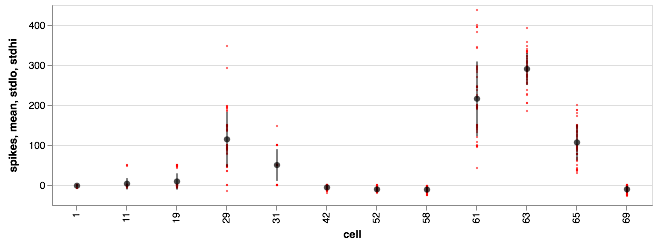

In [78]:
# plot it
def pinp_summary(pulse_summary_rep):
    pulse_summary = pulse_summary_rep.groupby('cell').agg({'spikes':['mean','std']})
    pulse_summary = pd.DataFrame(pulse_summary.to_records())
    col_names = pulse_summary.columns
    pulse_summary.rename(index=str, 
             columns={col_names[1]:'mean',
                      col_names[2]:'std'},
             inplace=True)
    pulse_summary['stdhi'] = pulse_summary['mean']+pulse_summary['std']
    pulse_summary['stdlo'] = pulse_summary['mean']-pulse_summary['std']

    chart = alt.Chart(pulse_summary_rep).mark_circle().encode(
        x = alt.X('cell:O'),      # X axis will be spike time
        y = alt.Y('spikes:Q' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(0.8),    # opaque
        color=alt.value('red')
    ).properties(
        width = 600,
        height = 200,
    )

    mean_point = alt.Chart(pulse_summary).mark_circle().encode(
        x = alt.X('cell:O'),
        y = alt.Y('mean:Q'),
        size=alt.value(40),
        color=alt.value('black')
    )


    bars = alt.Chart(pulse_summary).mark_rule().encode(
        y=alt.Y('stdlo:Q'),
        y2=alt.Y('stdhi:Q'),
        x=alt.X('cell:O'))

    return chart + mean_point + bars

chart = pinp_summary(pulse_summary_rep)
chart

How about the spike trains? We have information about the trains themselves - the interpulse-interval (amount of time between pulses), the pulse width, and the number of pulses. From that we can reconstruct when the laser was on and off with modular arithmetic

In [79]:
pinp_train = pinp[pinp['type']=='train']

# get stim information, assuming it's all the same across presentations
isi = pinp_train['isi'].iloc[0]
n_pulses = pinp_train['n_pulses'].iloc[0]
pulse_dur = pinp_train['pulse_width'].iloc[0]

print('ISI: {}ms, pulse duration: {}ms, n pulses: {}'.format(isi, pulse_dur, n_pulses))

ISI: 100.0ms, pulse duration: 10ms, n pulses: 10.0


In [82]:
30 % 2

0

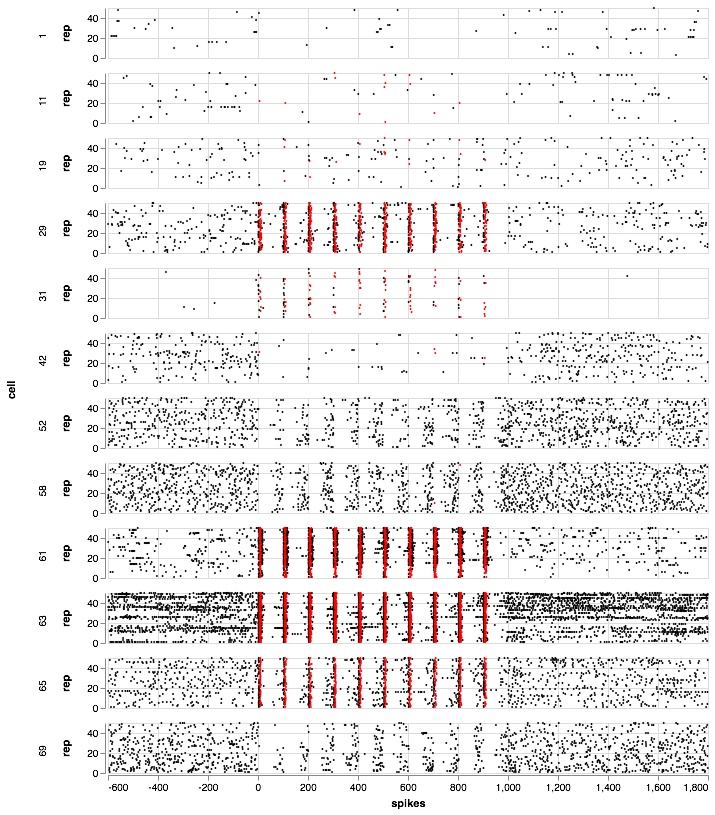

In [83]:
chart = alt.Chart(pinp_train).mark_circle().encode(
    x = alt.X('spikes'),      # X axis will be spike time
    y = alt.Y('rep' ),        # Y is the stimulus repetition
    size = alt.value(5),      # make the dots small
    opacity=alt.value(1.),    # opaque
    color=alt.condition(      # and...
        # if the spike happened during the stimulus presentation
        (alt.datum.spikes >= 0) & # spike after laser pulses start
        (alt.datum.spikes % alt.datum.isi < alt.datum.pulse_width+laser_slop) & # before the end of each pulse
        (alt.datum.spikes % alt.datum.isi > laser_slop) &                       # after the time it takes for the laser to take effect
        (alt.datum.spikes < alt.datum.isi * alt.datum.n_pulses),                # before the laser pulses stop
        alt.value('red'),     # colored red
        alt.value('black')    # otherwise black
    )
).properties(
    width = 600,
    height = 50,
).facet(
    row='cell',  # split the plot into rows by cell
)

chart

Now do the same analysis as before...

In [84]:
# now let's iterate and summarize
# we make some temporary lists to store our values
cell_l     = []
pulse_l    = []
rep_l      = []
evoked_l   = []
baseline_l = []
spikes_l   = []

# the protein has a bit of latency
laser_slop = 5. #ms
# how long before stim should we look for baseline?
pre_stim = 400. #ms

for i, group in pinp_train.groupby(['cell','rep']):
    # store uncalculated values
    cell_l.append(group['cell'].iloc[0])
    pulse_l.append(group['pulse_width'].iloc[0])
    rep_l.append(group['rep'].iloc[0])
    
    # calculate laser evoked spikes
    evoked = group[(group['spikes']>0)&
                   (group['spikes']%group['isi']>laser_slop) & 
                   (group['spikes']%group['isi']<group['pulse_width']+laser_slop)&
                   (group['spikes']<group['isi']*group['n_pulses'])].count()['spikes']
    # normalize to spikes/s
    evoked = evoked/((group['pulse_width'].iloc[0]*group['n_pulses'].iloc[0])/1000.)
    evoked_l.append(evoked)
    
    # and baseline
    baseline = group[(group['spikes']<0)&(group['spikes']>(pre_stim*-1))].count()['spikes']
    baseline = baseline/(pre_stim/1000.)
    baseline_l.append(baseline)
    
    # and the difference
    spikes_l.append(evoked-baseline)
    
#now wrap them up into a new df
train_summary_rep = pd.DataFrame({'cell':cell_l,
                              'pulse_width':pulse_l,
                              'rep':rep_l,
                              'evoked':evoked_l,
                              'baseline':baseline_l,
                              'spikes':spikes_l})


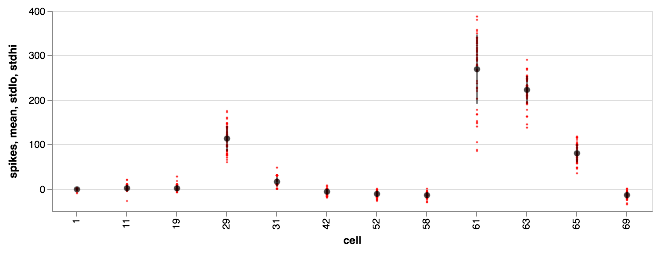

In [85]:
# plot it
chart = pinp_summary(train_summary_rep)
chart

Note that both of these analysis are measuring the same thing, so we can join them together :)

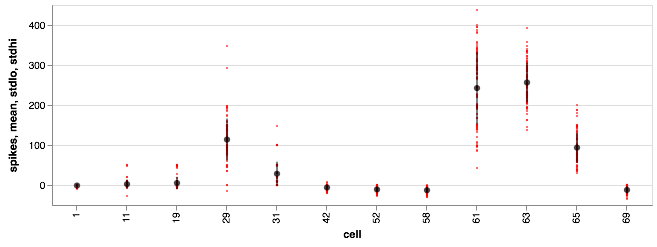

In [86]:
pinp_reps = pd.concat([pulse_summary_rep, train_summary_rep])

pinp_summary(pinp_reps)

## 5. Speech Sounds

What about the speech sounds? first let's load the sounds.

In [ ]:
# get the directory
sound_dir = os.path.join(os.getcwd(),'sounds','pshift16')
# make a string with a wildcard to search for the file
sound_search = sound_dir + os.sep + "*.wav"
sound_fns = glob(sound_search)
sound_fns

In [ ]:
sounds = {}
for fn in sound_fns:
    fs, wave = wavfile.read(fn)
    name = fn.split('/')[-1].split('.')[0]
    sounds[name] = wave
    

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(pinp_pulse['spikes']/1000., bins=30,zorder=1)
ax[0].scatter(pinp_pulse['spikes']/1000.,pinp_pulse['rep'],s=0.5,c='red',alpha=1.0,zorder=2)
ax[1].specgram(sounds['youregreat_pshift'],Fs=192000)
plt.show()